正在读取数据...
  baseline: 266 行数据
  1y: 266 行数据
  2y: 266 行数据
  3y: 266 行数据
  4y: 266 行数据
  5y: 266 行数据

成功读取 6 个时间点的数据

正在绘制趋势图...
多变量均值趋势图已保存: C:\Users\DXW\Desktop\outcom\趋势分析结果\临床指标均值时间趋势图.png

正在生成单变量均值趋势图...
  WOMKP 均值趋势图已保存
  WOMSTF 均值趋势图已保存
  WOMADL 均值趋势图已保存
  WOMTS 均值趋势图已保存
  KOOSKP 均值趋势图已保存
  KOOSYM 均值趋势图已保存

正在生成数据汇总表...
数据汇总表已保存: C:\Users\DXW\Desktop\outcom\趋势分析结果\数据汇总_均值和有效观测数.xlsx

正在生成简洁版趋势图...
简洁版趋势图已保存: C:\Users\DXW\Desktop\outcom\趋势分析结果\临床指标均值趋势图_简洁版.png

分析完成！所有结果已保存到: C:\Users\DXW\Desktop\outcom\趋势分析结果
生成的文件包括:
  1. 临床指标均值时间趋势图.png (六合一图表)
  2. 临床指标均值趋势图_简洁版.png (简洁版)
  3. 各个变量的单独均值趋势图
  4. 数据汇总_均值和有效观测数.xlsx (详细统计数据)


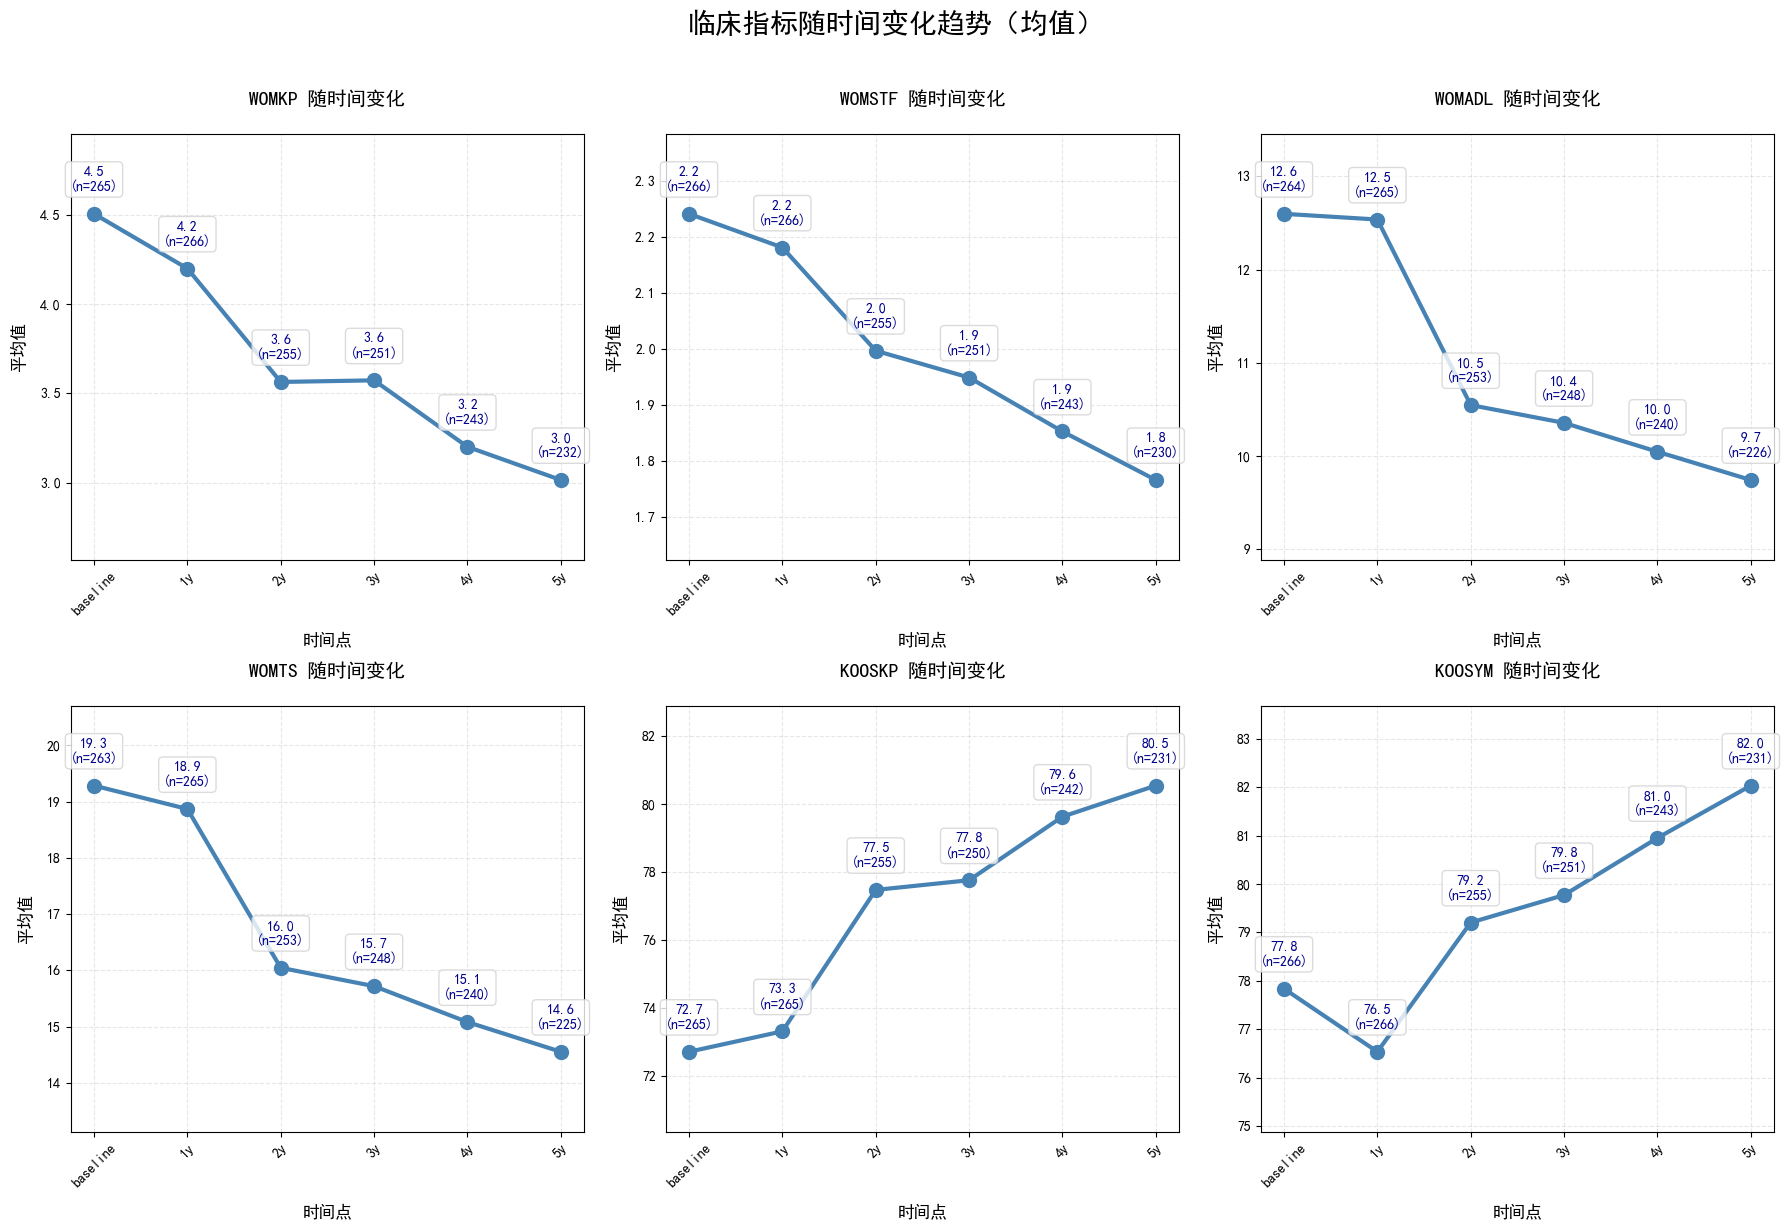

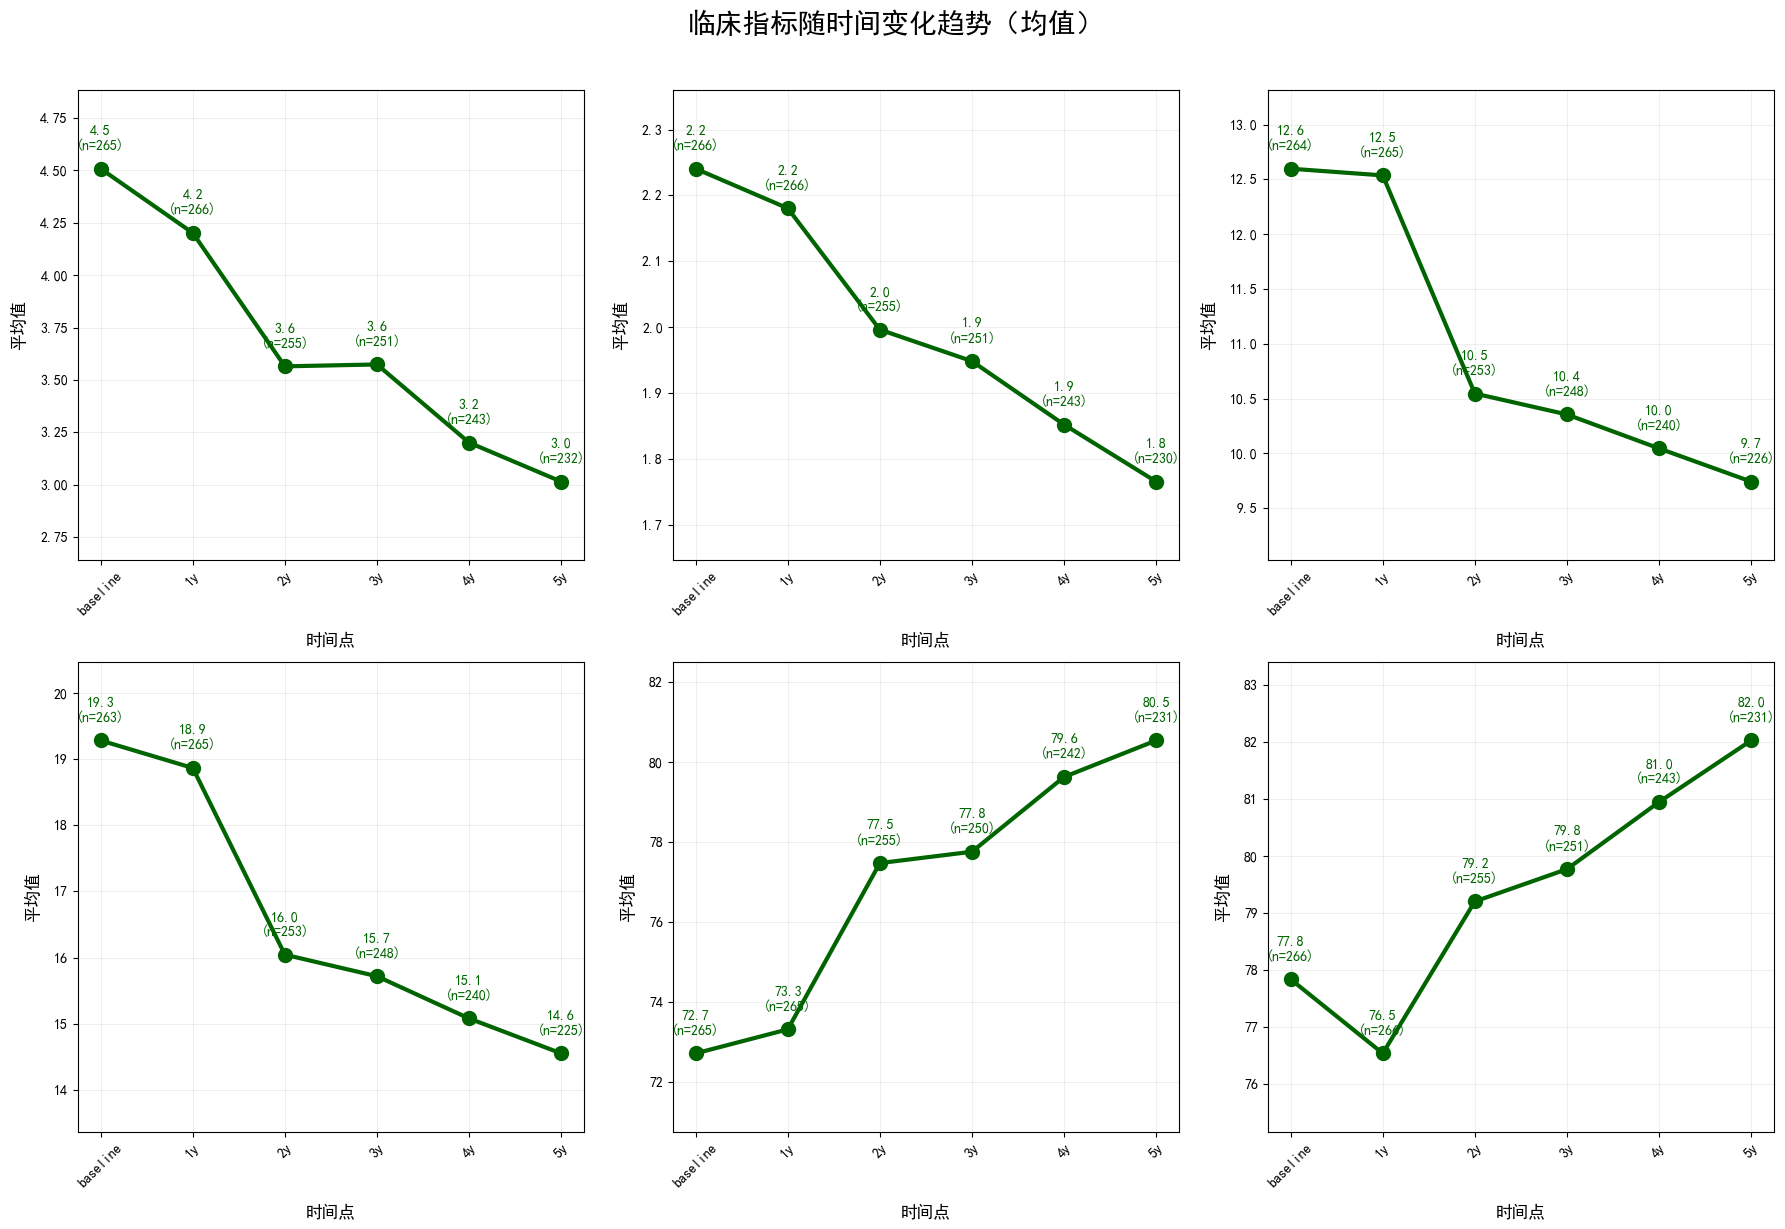

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
from matplotlib import rcParams

# ---------- 配置 ----------
# 设置中文字体（如果需要显示中文）
rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'DejaVu Sans']
rcParams['axes.unicode_minus'] = False

data_folder = r"C:\Users\DXW\Desktop\outcom" # 修改为你的数据文件夹路径

# 时间点文件定义（按时间顺序）
timepoint_files = [
    {'name': 'baseline', 'filename': '半月板手术_outcome_baseline.xlsx'},
    {'name': '1y', 'filename': '半月板手术_outcome_1y.xlsx'},
    {'name': '2y', 'filename': '半月板手术_outcome_2y.xlsx'},
    {'name': '3y', 'filename': '半月板手术_outcome_3y.xlsx'},
    {'name': '4y', 'filename': '半月板手术_outcome_4y.xlsx'},
    {'name': '5y', 'filename': '半月板手术_outcome_5y.xlsx'},

    # 可以根据需要添加更多时间点，例如：
    # {'name': '3y', 'filename': '3y.xlsx'},
]


# 要分析的变量
variables = ['WOMKP', 'WOMSTF', 'WOMADL', 'WOMTS', 'KOOSKP', 'KOOSYM']

# ---------- 1. 读取所有时间点数据 ----------
all_data = {}  # 存储格式: {时间点名称: DataFrame}

print("正在读取数据...")
for tp in timepoint_files:
    tp_name = tp['name']
    file_path = os.path.join(data_folder, tp['filename'])
    
    if not os.path.exists(file_path):
        print(f"警告: 文件不存在 - {file_path}")
        continue
    
    try:
        # 读取Excel文件中的'merged' sheet
        df = pd.read_excel(file_path, sheet_name='merged', dtype=str)
        
        # 标准化列名：去除空格并转为大写
        df.columns = df.columns.str.strip().str.upper()
        
        # 转换为数值类型（处理非数值数据）
        for var in variables:
            # 查找包含该变量名的列
            matching_cols = [col for col in df.columns if var in col.upper()]
            for col in matching_cols:
                df[col] = pd.to_numeric(df[col], errors='coerce')
        
        all_data[tp_name] = df
        print(f"  {tp_name}: {len(df)} 行数据")
        
    except Exception as e:
        print(f"  读取 {tp_name} 失败: {e}")

if not all_data:
    print("错误: 未读取到任何数据")
    exit()

print(f"\n成功读取 {len(all_data)} 个时间点的数据")

# ---------- 2. 计算每个时间点每个变量的平均值和有效观测数 ----------
# 存储每个变量的时间序列数据
var_trends = {var: {'timepoints': [], 'means': [], 'valid_counts': []} for var in variables}

for tp in timepoint_files:
    tp_name = tp['name']
    if tp_name not in all_data:
        continue
    
    df = all_data[tp_name]
    
    for var in variables:
        # 查找包含该变量名的列
        matching_cols = [col for col in df.columns if var in col.upper()]
        
        if matching_cols:
            # 如果找到多个匹配列，选择第一个
            col_name = matching_cols[0]
            
            # 计算平均值和有效观测数（非NaN的数量）
            mean_val = df[col_name].mean()
            valid_count = df[col_name].count()  # 非NaN的数量
            
            # 只记录有效数据（非NaN）
            if pd.notna(mean_val):
                var_trends[var]['timepoints'].append(tp_name)
                var_trends[var]['means'].append(mean_val)
                var_trends[var]['valid_counts'].append(valid_count)
            else:
                print(f"  注意: {tp_name} 中变量 {var} 均值为NaN")
        else:
            print(f"  警告: {tp_name} 中未找到变量 {var}")

# ---------- 3. 为每个变量绘制趋势图 ----------
print("\n正在绘制趋势图...")

# 创建输出文件夹（在数据文件夹下）
output_dir = os.path.join(data_folder, "趋势分析结果")
os.makedirs(output_dir, exist_ok=True)

# 创建6个子图的画布
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('临床指标随时间变化趋势（均值）', fontsize=20, fontweight='bold', y=1.02)

# 为每个变量绘制图表
for idx, var in enumerate(variables):
    ax = axes[idx // 3, idx % 3]
    
    timepoints = var_trends[var]['timepoints']
    means = var_trends[var]['means']
    valid_counts = var_trends[var]['valid_counts']
    
    if len(timepoints) >= 2:
        # 绘制折线图（只要均值线）
        ax.plot(timepoints, means, marker='o', linewidth=3, markersize=10, color='steelblue')
        
        # 添加数据标签（均值和有效观测数）
        for i, (x, y, count) in enumerate(zip(timepoints, means, valid_counts)):
            # 在数据点上方标注
            ax.annotate(f'{y:.1f}\n(n={count})', xy=(x, y), xytext=(0, 15),
                       textcoords='offset points', ha='center', va='bottom',
                       fontsize=10, fontweight='bold', color='darkblue',
                       bbox=dict(boxstyle="round,pad=0.3", facecolor="white", 
                                 edgecolor="lightgray", alpha=0.8))
        
        # 设置图表属性
        ax.set_title(f'{var} 随时间变化', fontsize=14, fontweight='bold', pad=20)
        ax.set_xlabel('时间点', fontsize=12, labelpad=10)
        ax.set_ylabel('平均值', fontsize=12, labelpad=10)
        
        # 自动调整y轴范围，留出标注空间
        if len(means) > 0:
            y_min, y_max = min(means), max(means)
            y_range = y_max - y_min
            padding = y_range * 0.3 if y_range > 0 else abs(y_max) * 0.3 if y_max != 0 else 1
            ax.set_ylim([y_min - padding, y_max + padding])
        
        # 添加网格
        ax.grid(True, alpha=0.3, linestyle='--')
        
        # 旋转x轴标签
        ax.tick_params(axis='x', rotation=45)
        
    elif len(timepoints) == 1:
        # 只有一个时间点的情况
        x = timepoints[0]
        y = means[0]
        count = valid_counts[0]
        
        ax.scatter(x, y, s=100, color='steelblue')
        ax.annotate(f'{y:.1f}\n(n={count})', xy=(x, y), xytext=(0, 15),
                   textcoords='offset points', ha='center', va='bottom',
                   fontsize=10, fontweight='bold', color='darkblue',
                   bbox=dict(boxstyle="round,pad=0.3", facecolor="white", 
                             edgecolor="lightgray", alpha=0.8))
        
        ax.set_title(f'{var} 随时间变化', fontsize=14, fontweight='bold', pad=20)
        ax.set_xlabel('时间点', fontsize=12, labelpad=10)
        ax.set_ylabel('平均值', fontsize=12, labelpad=10)
        ax.grid(True, alpha=0.3, linestyle='--')
        
    else:
        ax.text(0.5, 0.5, f'{var}\n无有效数据', 
               ha='center', va='center', transform=ax.transAxes, 
               fontsize=14, color='gray')
        ax.set_title(f'{var} 随时间变化', fontsize=14, fontweight='bold', pad=20)

# 调整布局
plt.tight_layout()

# 保存图表
output_path = os.path.join(output_dir, f'临床指标均值时间趋势图.png')
plt.savefig(output_path, dpi=300, bbox_inches='tight')
print(f"多变量均值趋势图已保存: {output_path}")

# ---------- 4. 为每个变量单独保存图表 ----------
print("\n正在生成单变量均值趋势图...")
for var in variables:
    fig, ax = plt.subplots(figsize=(10, 6))
    
    timepoints = var_trends[var]['timepoints']
    means = var_trends[var]['means']
    valid_counts = var_trends[var]['valid_counts']
    
    if len(timepoints) >= 2:
        # 绘制折线图
        ax.plot(timepoints, means, marker='o', linewidth=3, markersize=10, color='crimson')
        
        # 添加数据点标签
        for i, (x, y, count) in enumerate(zip(timepoints, means, valid_counts)):
            ax.annotate(f'{y:.1f}\n(n={count})', xy=(x, y), xytext=(0, 15),
                       textcoords='offset points', ha='center', va='bottom',
                       fontsize=11, fontweight='bold', color='darkred',
                       bbox=dict(boxstyle="round,pad=0.3", facecolor="white", 
                                 edgecolor="lightgray", alpha=0.9))
        
        # 设置图表属性
        ax.set_title(f'{var} 均值随时间变化趋势', fontsize=16, fontweight='bold', pad=20)
        ax.set_xlabel('时间点', fontsize=12, labelpad=10)
        ax.set_ylabel('平均值', fontsize=12, labelpad=10)
        
        # 自动调整y轴范围
        if len(means) > 0:
            y_min, y_max = min(means), max(means)
            y_range = y_max - y_min
            padding = y_range * 0.3 if y_range > 0 else abs(y_max) * 0.3 if y_max != 0 else 1
            ax.set_ylim([y_min - padding, y_max + padding])
        
        # 添加网格
        ax.grid(True, alpha=0.3, linestyle=':')
        
        # 旋转x轴标签
        ax.tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        
        # 保存图表
        var_output_path = os.path.join(output_dir, f'{var}_均值时间趋势图.png')
        plt.savefig(var_output_path, dpi=300, bbox_inches='tight')
        print(f"  {var} 均值趋势图已保存")
        
    elif len(timepoints) == 1:
        x = timepoints[0]
        y = means[0]
        count = valid_counts[0]
        
        ax.scatter(x, y, s=100, color='crimson')
        ax.annotate(f'{y:.1f}\n(n={count})', xy=(x, y), xytext=(0, 15),
                   textcoords='offset points', ha='center', va='bottom',
                   fontsize=11, fontweight='bold', color='darkred',
                   bbox=dict(boxstyle="round,pad=0.3", facecolor="white", 
                             edgecolor="lightgray", alpha=0.9))
        
        ax.set_title(f'{var} 均值随时间变化趋势', fontsize=16, fontweight='bold', pad=20)
        ax.set_xlabel('时间点', fontsize=12, labelpad=10)
        ax.set_ylabel('平均值', fontsize=12, labelpad=10)
        ax.grid(True, alpha=0.3, linestyle=':')
        
        plt.tight_layout()
        var_output_path = os.path.join(output_dir, f'{var}_均值时间趋势图.png')
        plt.savefig(var_output_path, dpi=300, bbox_inches='tight')
        print(f"  {var} 均值趋势图已保存")
        
    else:
        print(f"  {var}: 无有效数据，跳过")
        
    plt.close()

# ---------- 5. 生成数据汇总表 ----------
print("\n正在生成数据汇总表...")

summary_rows = []
for tp in timepoint_files:
    tp_name = tp['name']
    if tp_name in all_data:
        df = all_data[tp_name]
        row = {'时间点': tp_name}
        
        for var in variables:
            matching_cols = [col for col in df.columns if var in col.upper()]
            if matching_cols:
                col_name = matching_cols[0]
                mean_val = df[col_name].mean()
                valid_count = df[col_name].count()
                row[f'{var}_均值'] = mean_val if pd.notna(mean_val) else np.nan
                row[f'{var}_有效观测数'] = valid_count
            else:
                row[f'{var}_均值'] = np.nan
                row[f'{var}_有效观测数'] = 0
        
        summary_rows.append(row)

if summary_rows:
    summary_df = pd.DataFrame(summary_rows)
    summary_path = os.path.join(output_dir, '数据汇总_均值和有效观测数.xlsx')
    summary_df.to_excel(summary_path, index=False)
    print(f"数据汇总表已保存: {summary_path}")

# ---------- 6. 生成简洁版图表（不要子标题，只要大标题） ----------
print("\n正在生成简洁版趋势图...")

fig2, axes2 = plt.subplots(2, 3, figsize=(18, 12))
fig2.suptitle('临床指标随时间变化趋势（均值）', fontsize=20, fontweight='bold', y=1.02)

for idx, var in enumerate(variables):
    ax = axes2[idx // 3, idx % 3]
    
    timepoints = var_trends[var]['timepoints']
    means = var_trends[var]['means']
    valid_counts = var_trends[var]['valid_counts']
    
    if len(timepoints) >= 1:
        # 绘制折线图（只要均值线）
        if len(timepoints) >= 2:
            ax.plot(timepoints, means, marker='o', linewidth=3, markersize=10, color='darkgreen')
        else:
            ax.scatter(timepoints, means, s=100, color='darkgreen')
        
        # 添加数据标签（均值和有效观测数）
        for i, (x, y, count) in enumerate(zip(timepoints, means, valid_counts)):
            ax.annotate(f'{y:.1f}\n(n={count})', xy=(x, y), xytext=(0, 12),
                       textcoords='offset points', ha='center', va='bottom',
                       fontsize=10, fontweight='bold', color='darkgreen')
        
        # 设置图表属性
        ax.set_xlabel('时间点', fontsize=12, labelpad=10)
        ax.set_ylabel('平均值', fontsize=12, labelpad=10)
        
        # 自动调整y轴范围
        if len(means) > 0:
            y_min, y_max = min(means), max(means)
            y_range = y_max - y_min
            padding = y_range * 0.25 if y_range > 0 else abs(y_max) * 0.25 if y_max != 0 else 1
            ax.set_ylim([y_min - padding, y_max + padding])
        
        # 添加网格
        ax.grid(True, alpha=0.2, linestyle='-')
        
        # 旋转x轴标签
        ax.tick_params(axis='x', rotation=45)
        
    else:
        ax.text(0.5, 0.5, f'{var}\n无数据', 
               ha='center', va='center', transform=ax.transAxes, 
               fontsize=12, color='gray')
        ax.set_xlabel('时间点', fontsize=12, labelpad=10)
        ax.set_ylabel('平均值', fontsize=12, labelpad=10)

# 调整布局
plt.tight_layout()

# 保存图表
simple_output_path = os.path.join(output_dir, f'临床指标均值趋势图_简洁版.png')
plt.savefig(simple_output_path, dpi=300, bbox_inches='tight')
print(f"简洁版趋势图已保存: {simple_output_path}")

print(f"\n分析完成！所有结果已保存到: {output_dir}")
print("生成的文件包括:")
print(f"  1. 临床指标均值时间趋势图.png (六合一图表)")
print(f"  2. 临床指标均值趋势图_简洁版.png (简洁版)")
print(f"  3. 各个变量的单独均值趋势图")
print(f"  4. 数据汇总_均值和有效观测数.xlsx (详细统计数据)")